<a href="https://colab.research.google.com/github/abonti123/Used-Car-Price-Prediction-Using-Machine-Learning/blob/main/Car_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving car_price_prediction (1).csv to car_price_prediction (1).csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   Prod. year        19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  object
 11  Cylinders         19237 non-null  int64 
 12  Gear box type     19237 non-null  object
 13  Drive wheels      19237 non-null  object
 14  Doors             19237 non-null  object
 15  Wheel             19237 non-null  object
 16  Color             19237 non-null  object
 17  Airbags     

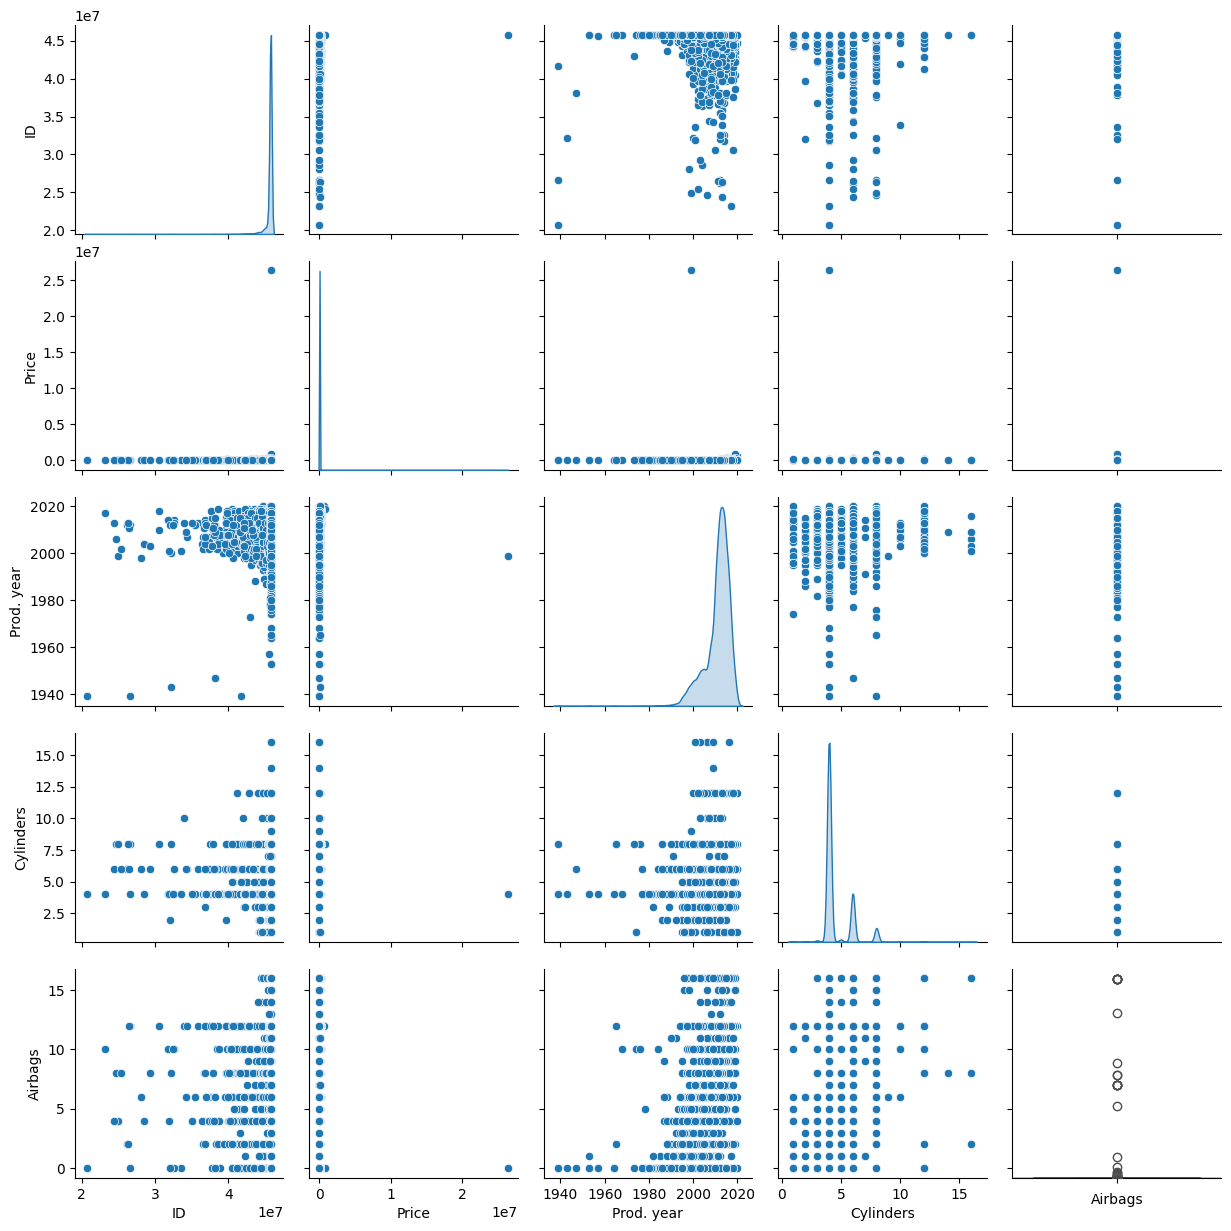

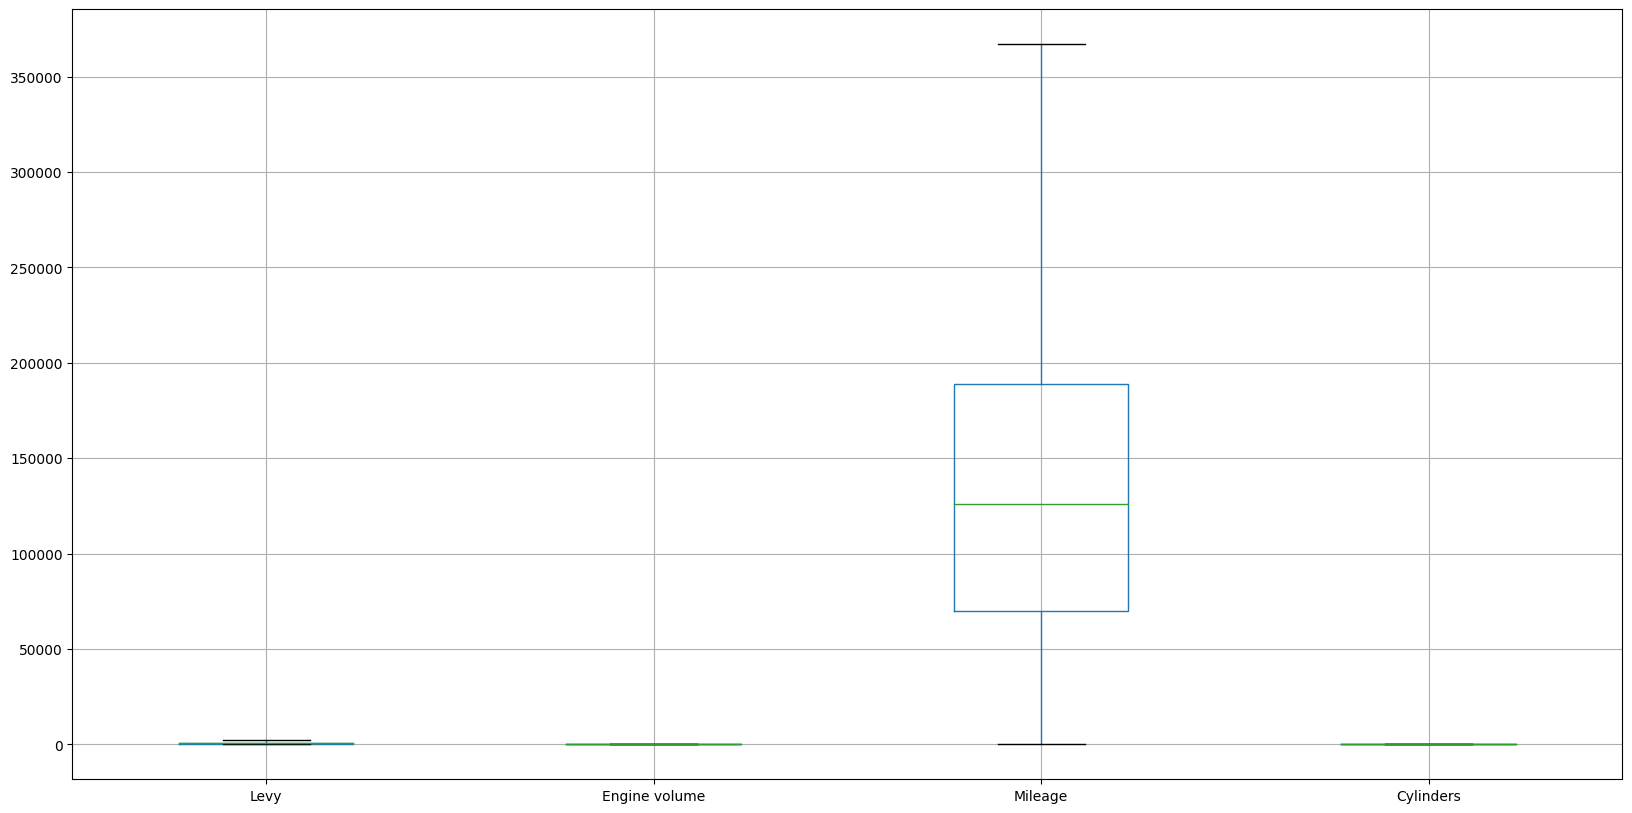

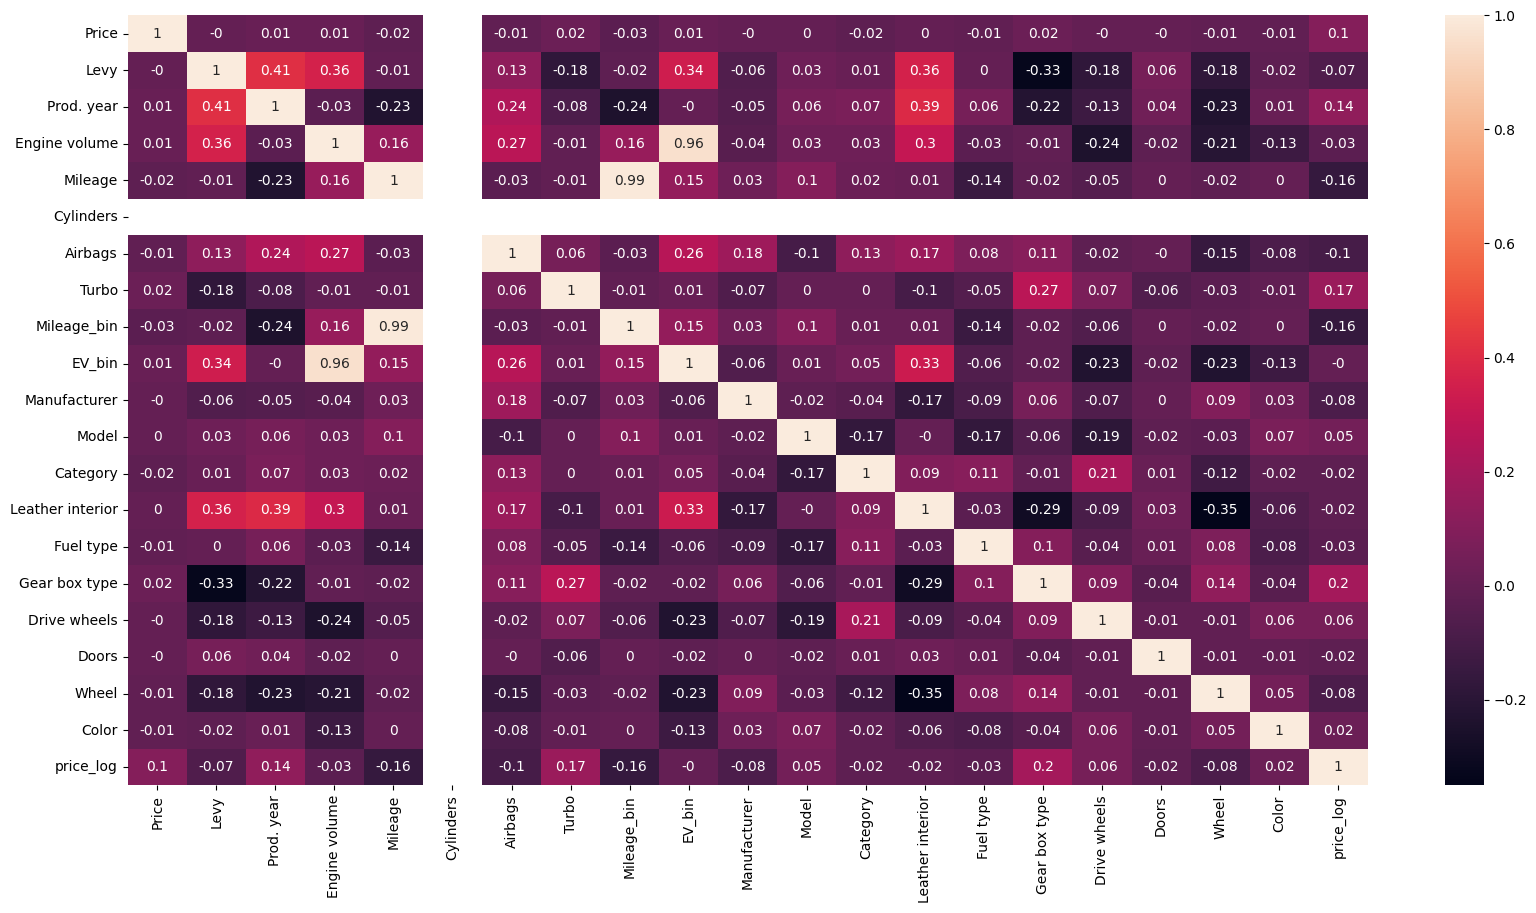

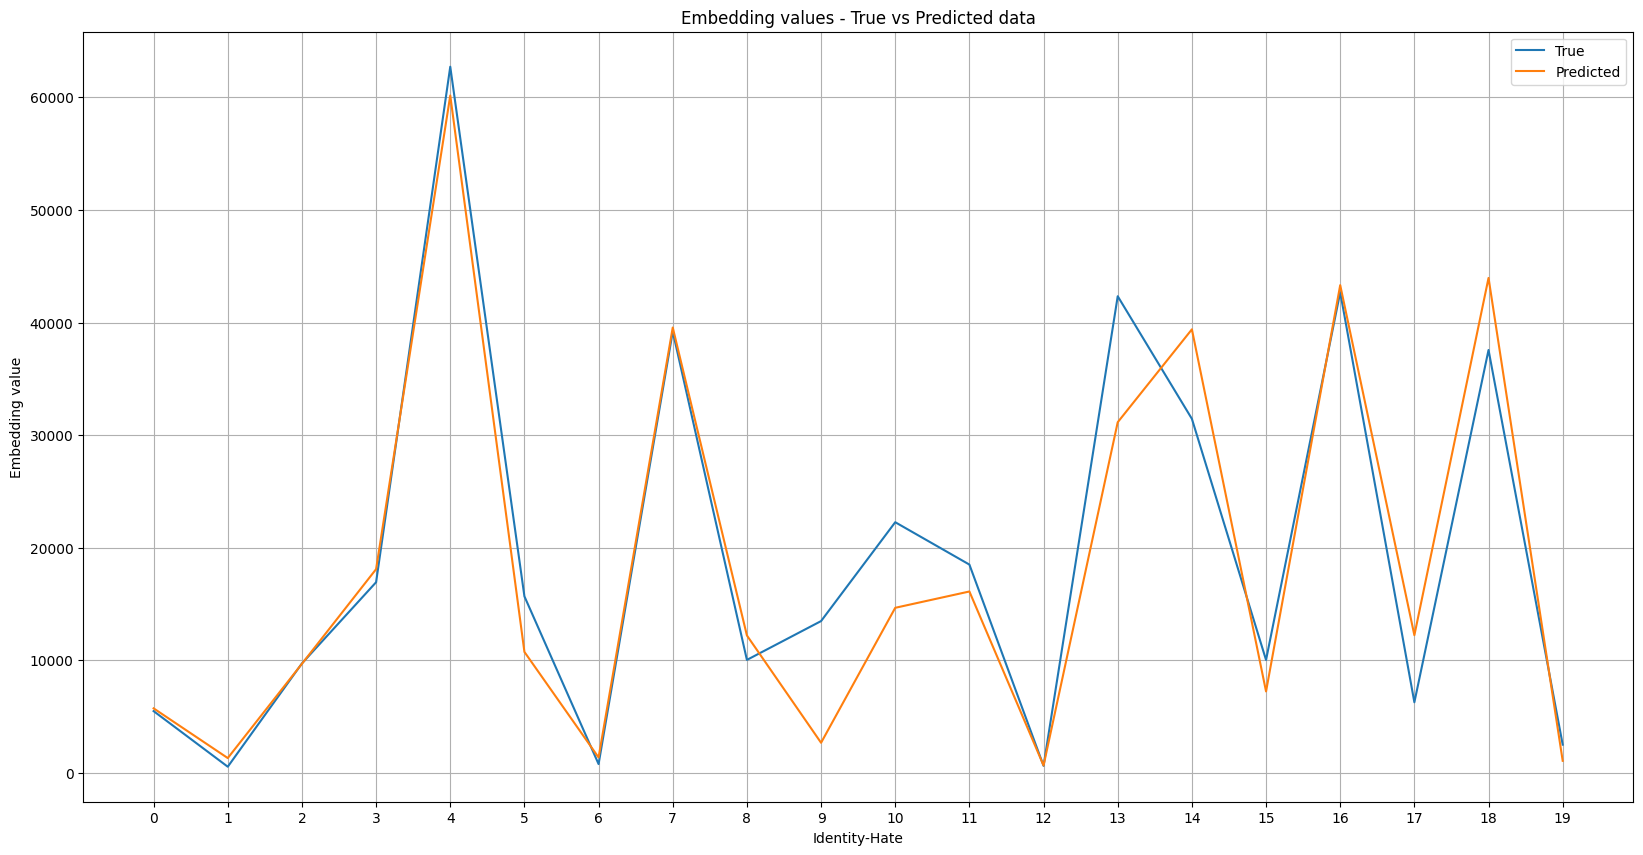

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from prettytable import PrettyTable

df=pd.read_csv('car_price_prediction (1).csv') #Reading the csv file

# Data Inspection

df.shape
df.describe().transpose()
df.info()
sns.pairplot(df, diag_kind='kde')

# Data Preprocessing

df.drop('ID',axis=1,inplace=True)
df['Levy']=df['Levy'].replace('-',np.nan)
df['Levy']=df['Levy'].astype(float)
levy_mean=0
#cleaning levy column
df['Levy'].fillna(levy_mean,inplace=True)
df['Levy']=round(df['Levy'],2)
#cleaning mileage column
df['Mileage']=df['Mileage'].apply(lambda x:x.split(' ')[0])
df['Mileage']=df['Mileage'].astype('int')
#cleaning Enigine column
df['Engine volume'].unique()
df['Turbo']=df['Engine volume'].apply(lambda x:1 if 'Turbo' in str(x) else 0)
df['Engine volume']=df['Engine volume'].apply(lambda x:str(x).replace('Turbo',''))
df['Engine volume']=df['Engine volume'].astype(float)
#Observing and finding outliers
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[0]]);
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[1]]);
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[2]]);
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[3]]);
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[4]]);
#After plotting we can observe that ‘Levy’,’Engine volume’, ‘Mileage’, ‘Cylinders’ columns has outliers
def find_outliers_limit(df,col):
    print(col)
    print('-'*50)
    #removing outliers
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower:',lower,' Upper:',upper)
    return lower,upper
def remove_outlier(df,col,upper,lower):
    # identify outliers
    outliers = [x for x in df[col] if x == upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in df[col] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    final= np.where(df[col]>upper,upper,np.where(df[col]<lower,lower,df[col]))
    return final
outlier_cols=['Levy','Engine volume','Mileage','Cylinders']
for col in outlier_cols:
    lower,upper=find_outliers_limit(df,col)
    df[col]=remove_outlier(df,col,upper,lower)
#boxplot - to see outliers
plt.figure(figsize=(20,10))
df[outlier_cols].boxplot()
df['Doors'].unique()
df['Doors']=df['Doors'].map({'04-May':'4_5','02-Mar':'2_3','>5':'5'})
df['Doors']=df['Doors'].astype(str)

#Creating Additional Features

labels=[0,1,2,3,4,5,6,7,8,9]
df['Mileage_bin']=pd.cut(df['Mileage'],len(labels),labels=labels)
df['Mileage_bin']=df['Mileage_bin'].astype(float)
labels=[0,1,2,3,4]
df['EV_bin']=pd.cut(df['Engine volume'],len(labels),labels=labels)
df['EV_bin']=df['EV_bin'].astype(float)

#Handling Categorical features

num_df=df.select_dtypes(include=np.number)
cat_df=df.select_dtypes(include=object)
encoding=OrdinalEncoder()
cat_cols=cat_df.columns.tolist()
encoding.fit(cat_df[cat_cols])
cat_oe=encoding.transform(cat_df[cat_cols])
cat_oe=pd.DataFrame(cat_oe,columns=cat_cols)
cat_df.reset_index(inplace=True,drop=True)
cat_oe.head()
num_df.reset_index(inplace=True,drop=True)
cat_oe.reset_index(inplace=True,drop=True)
final_all_df=pd.concat([num_df,cat_oe],axis=1)

#Checking correlation

final_all_df['price_log']=np.log(final_all_df['Price'])
plt.figure(figsize=(20,10))
sns.heatmap(round(final_all_df.corr(),2),annot=True);
cols_drop=['Price','price_log','Cylinders']
final_all_df.columns
X=final_all_df.drop(cols_drop,axis=1)
y=final_all_df['Price']

# Data Splitting and Scaling

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=25)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Model Building

def train_ml_model(x,y,model_type):

    if model_type=='lr':

        model=LinearRegression()

    elif model_type=='xgb':

        model=XGBRegressor()

    elif model_type=='rf':

        model=RandomForestRegressor()

    model.fit(X_train_scaled,np.log(y))

    return model

def model_evaluate(model,x,y):
    predictions=model.predict(x)
    predictions=np.exp(predictions)
    mse=mean_squared_error(y,predictions)
    mae=mean_absolute_error(y,predictions)

    mape=mean_absolute_percentage_error(y,predictions)

    msle=mean_squared_log_error(y,predictions)

    mse=round(mse,2)

    mae=round(mae,2)

    mape=round(mape,2)

    msle=round(msle,2)

    return [mse,mae,mape,msle]

model_lr=train_ml_model(X_train_scaled,y_train,'lr')
model_xgb=train_ml_model(X_train_scaled,y_train,'xgb')
model_rf=train_ml_model(X_train_scaled,y_train,'rf')

#visualizing result using random forest

y_pred=np.exp(model_rf.predict(X_test_scaled))
number_of_observations=20
x_ax = range(len(y_test[:number_of_observations]))
plt.figure(figsize=(20,10))
plt.plot(x_ax, y_test[:number_of_observations], label="True")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Embedding values - True vs Predicted data")
plt.xlabel('Identity-Hate')
plt.ylabel('Embedding value')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluate models
models = {'Linear Regression': model_lr, 'XGBoost': model_xgb, 'Random Forest': model_rf}
metrics = {'Model': [], 'MSE': [], 'MAE': [], 'MAPE': [], 'MSLE': []}

for name, model in models.items():
    mse, mae, mape, msle = model_evaluate(model, X_test_scaled, y_test)
    metrics['Model'].append(name)
    metrics['MSE'].append(mse)
    metrics['MAE'].append(mae)
    metrics['MAPE'].append(mape)
    metrics['MSLE'].append(msle)

# Display results
table = PrettyTable()
table.field_names = ['Model', 'MSE', 'MAE', 'MAPE', 'MSLE']
for i in range(len(metrics['Model'])):
    table.add_row([metrics['Model'][i], metrics['MSE'][i], metrics['MAE'][i], metrics['MAPE'][i], metrics['MSLE'][i]])

print(table)


+-------------------+--------------+----------+------+------+
|       Model       |     MSE      |   MAE    | MAPE | MSLE |
+-------------------+--------------+----------+------+------+
| Linear Regression | 337229137.72 | 11116.29 | 6.88 | 2.04 |
|      XGBoost      | 172382653.58 | 6139.72  | 3.31 | 0.89 |
|   Random Forest   | 110151758.09 | 4635.33  | 3.09 | 0.8  |
+-------------------+--------------+----------+------+------+


In [ ]:
from sklearn.metrics import r2_score

# Evaluate models
models = {'Linear Regression': model_lr, 'XGBoost': model_xgb, 'Random Forest': model_rf}
r2_scores = {}

for name, model in models.items():
    predictions = np.exp(model.predict(X_test_scaled))
    r2 = r2_score(y_test, predictions)
    r2_scores[name] = r2

# Display R-squared scores
print("R-squared scores:")
for name, r2 in r2_scores.items():
    print(f"{name}: {r2:.4f}")


R-squared scores:
Linear Regression: 0.0515
XGBoost: 0.5151
Random Forest: 0.6902


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                304       
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 4)                 36        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

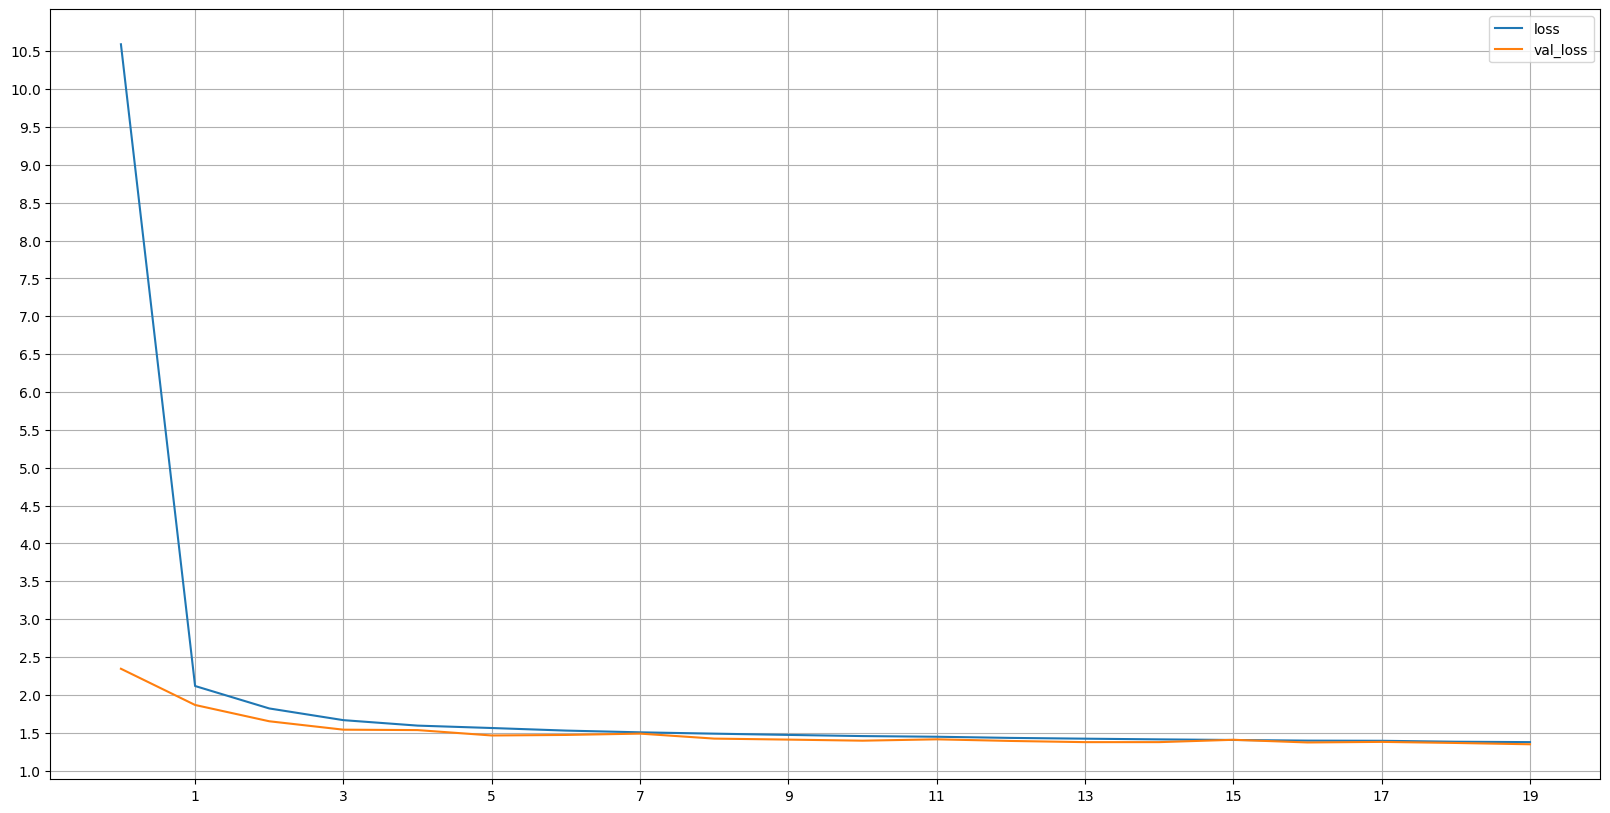

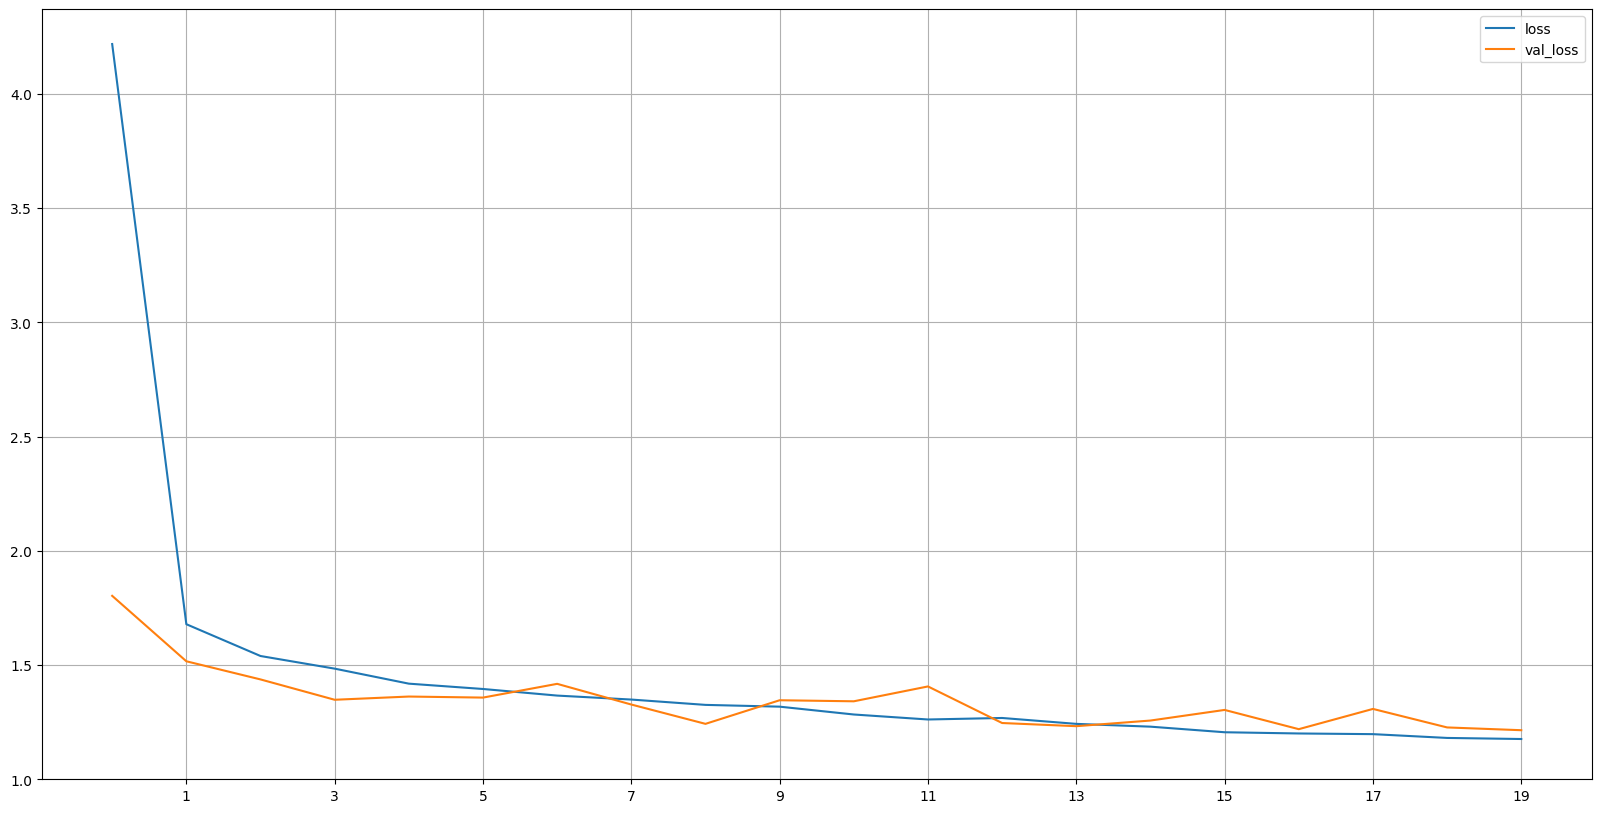

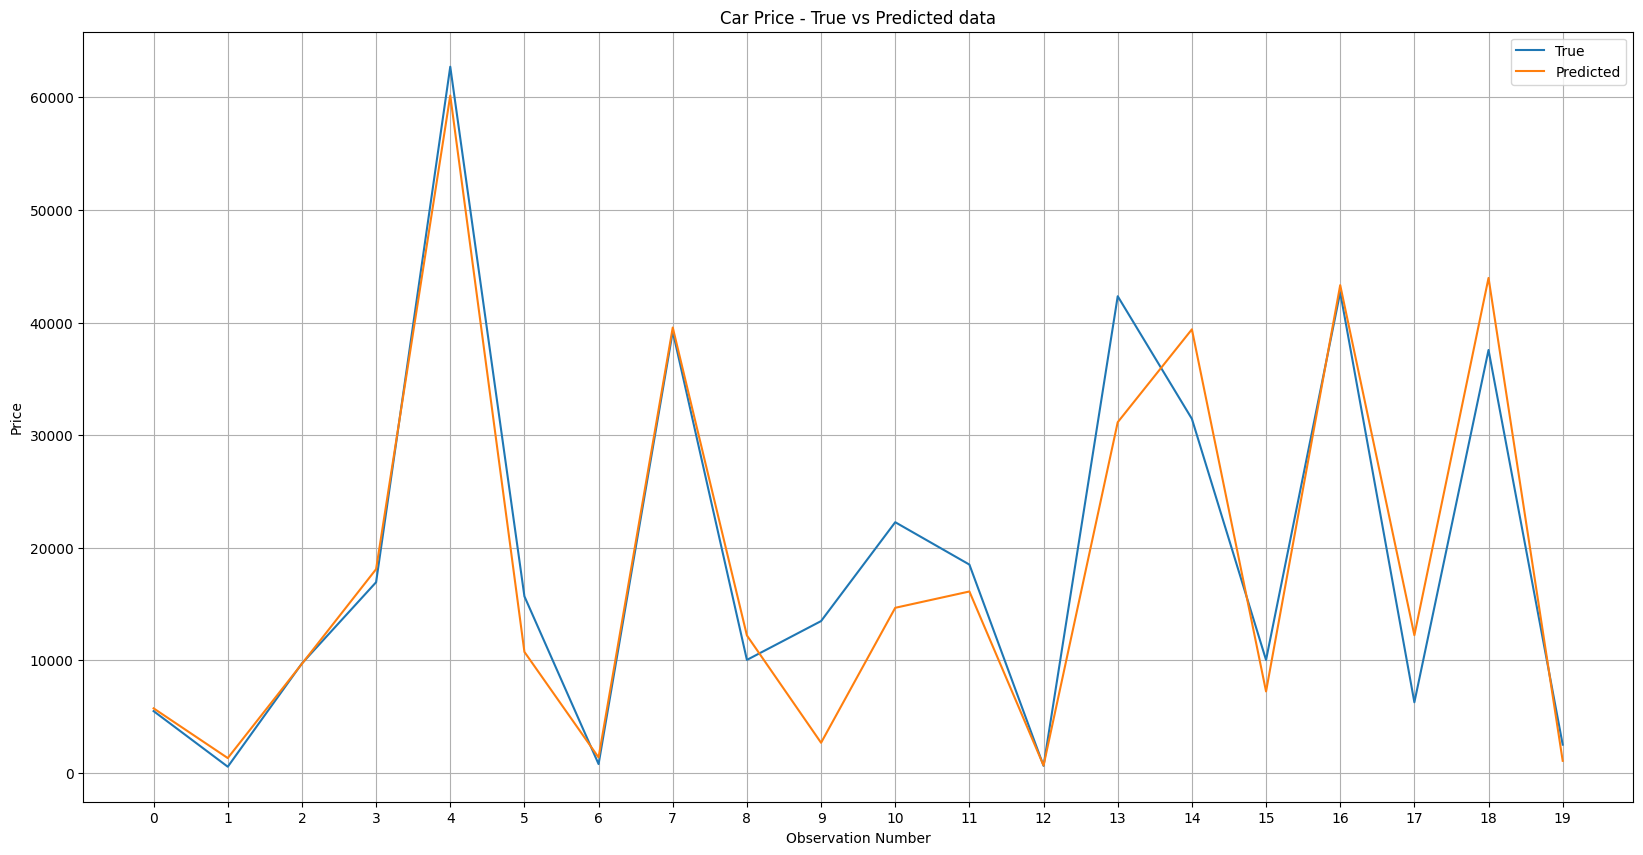

In [ ]:
#Small Network

model_dl_small=Sequential()

model_dl_small.add(Dense(16,input_dim=X_train_scaled.shape[1],activation='relu'))

model_dl_small.add(Dense(8,activation='relu'))

model_dl_small.add(Dense(4,activation='relu'))

model_dl_small.add(Dense(1,activation='linear'))

model_dl_small.compile(loss='mean_squared_error',optimizer='adam')

model_dl_small.summary()

epochs=20

batch_size=10

model_dl_small.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)

#plot the loss and validation loss of the dataset

history_df = pd.DataFrame(model_dl_small.history.history)

plt.figure(figsize=(20,10))

plt.plot(history_df['loss'], label='loss')

plt.plot(history_df['val_loss'], label='val_loss')

plt.xticks(np.arange(1,epochs+1,2))

plt.yticks(np.arange(1,max(history_df['loss']),0.5))

plt.legend()

plt.grid()

### Large Network

model_dl_large=Sequential()

model_dl_large.add(Dense(64,input_dim=X_train_scaled.shape[1],activation='relu'))

model_dl_large.add(Dense(32,activation='relu'))

model_dl_large.add(Dense(16,activation='relu'))

model_dl_large.add(Dense(1,activation='linear'))

model_dl_large.compile(loss='mean_squared_error',optimizer='adam')

model_dl_large.summary()

epochs=20

batch_size=10

model_dl_large.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)

from sklearn.svm import SVR  # Import SVR for Support Vector Regression

# Train SVR model
model_svm = SVR()
model_svm.fit(X_train_scaled, np.log(y_train))
# Evaluate SVR model
svm_metrics = model_evaluate(model_svm, X_test_scaled, y_test)


#plot the loss and validation loss of the dataset

history_df = pd.DataFrame(model_dl_large.history.history)

plt.figure(figsize=(20,10))

plt.plot(history_df['loss'], label='loss')

plt.plot(history_df['val_loss'], label='val_loss')

plt.xticks(np.arange(1,epochs+1,2))

plt.yticks(np.arange(1,max(history_df['loss']),0.5))

plt.legend()

plt.grid()

summary=PrettyTable(['Model','MSE','MAE','MAPE','MSLE'])

summary.add_row(['LR']+model_evaluate(model_lr,X_test_scaled,y_test))

summary.add_row(['XGB']+model_evaluate(model_xgb,X_test_scaled,y_test))

summary.add_row(['RF']+model_evaluate(model_rf,X_test_scaled,y_test))

summary.add_row(['DL_SMALL']+model_evaluate(model_dl_small,X_test_scaled,y_test))

summary.add_row(['DL_LARGE']+model_evaluate(model_dl_large,X_test_scaled,y_test))

summary.add_row(['SVM'] + svm_metrics)



print(summary)

y_pred=np.exp(model_rf.predict(X_test_scaled))

number_of_observations=20

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(20,10))

plt.plot(x_ax, y_test[:number_of_observations], label="True")

plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")

plt.title("Car Price - True vs Predicted data")

plt.xlabel('Observation Number')

plt.ylabel('Price')

plt.xticks(np.arange(number_of_observations))

plt.legend()

plt.grid()

plt.show()

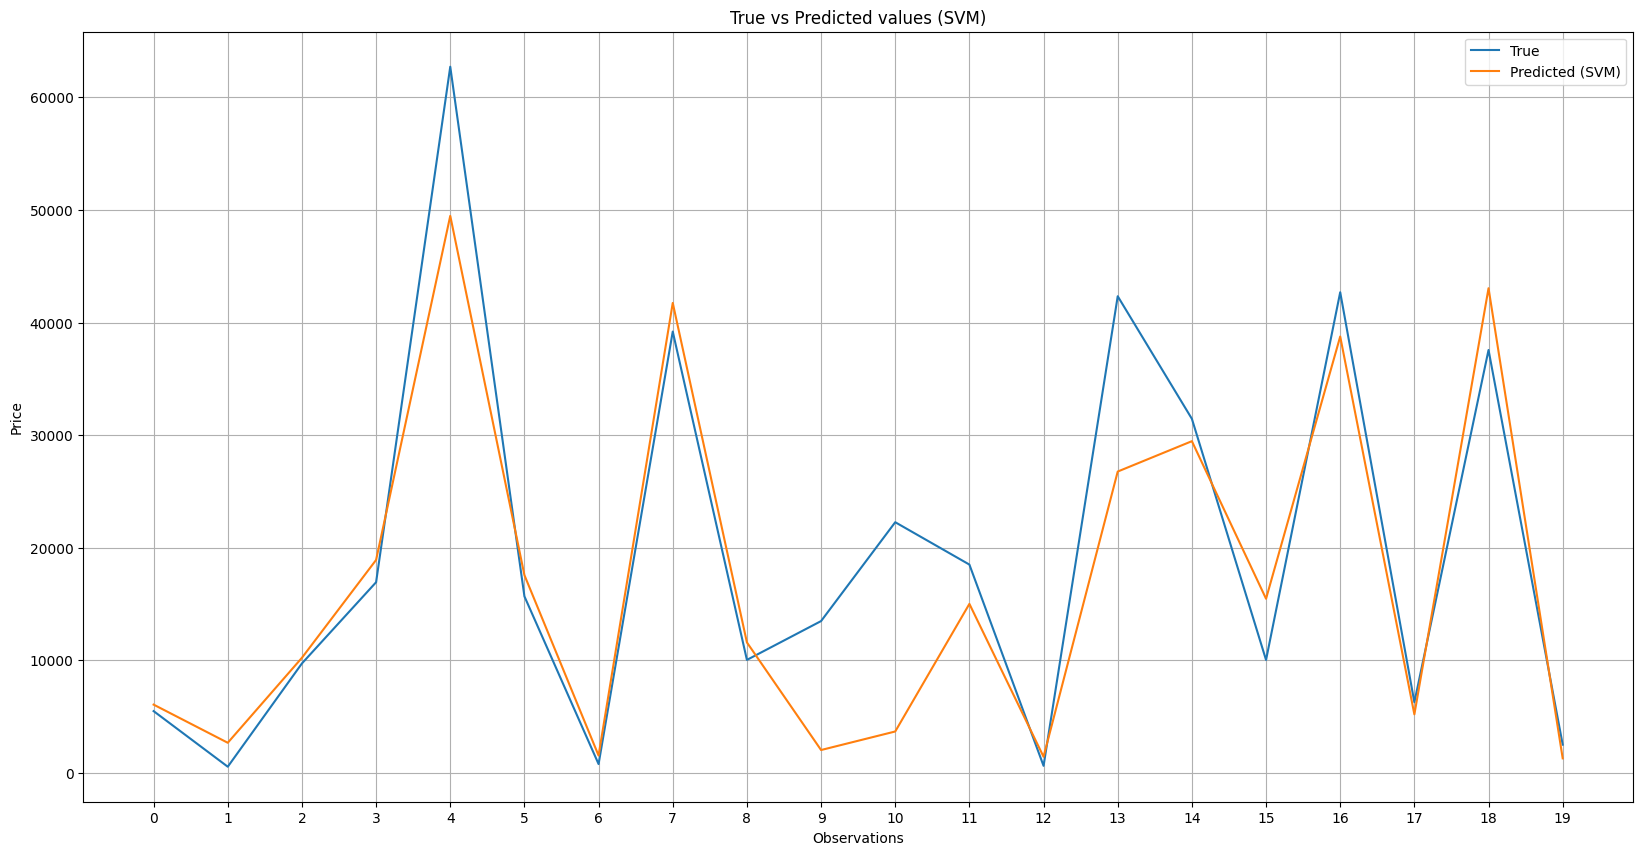

In [ ]:
from sklearn.svm import SVR

# Model Building
def train_ml_model(x, y, model_type):
    if model_type == 'lr':
        model = LinearRegression()
    elif model_type == 'xgb':
        model = XGBRegressor()
    elif model_type == 'rf':
        model = RandomForestRegressor()
    elif model_type == 'svm':
        model = SVR(kernel='rbf')  # Using Radial Basis Function (RBF) kernel for SVM
    model.fit(X_train_scaled, np.log(y))
    return model

# Train SVM model
model_svm = train_ml_model(X_train_scaled, y_train, 'svm')

# Model Evaluation
def model_evaluate(model, x, y):
    predictions = model.predict(x)
    predictions = np.exp(predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    msle = mean_squared_log_error(y, predictions)
    mse = round(mse, 2)
    mae = round(mae, 2)
    mape = round(mape, 2)
    msle = round(msle, 2)
    return [mse, mae, mape, msle]

# Evaluate SVM model
svm_eval_metrics = model_evaluate(model_svm, X_test_scaled, y_test)

# Visualize the predictions versus the true values for SVM model
y_pred_svm = np.exp(model_svm.predict(X_test_scaled))
number_of_observations = 20
x_ax = range(len(y_test[:number_of_observations]))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, y_test[:number_of_observations], label="True")
plt.plot(x_ax, y_pred_svm[:number_of_observations], label="Predicted (SVM)")
plt.title("True vs Predicted values (SVM)")
plt.xlabel('Observations')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Model Evaluation for SVM
def model_evaluate_svm(model, x, y):
    predictions = model.predict(x)
    predictions = np.exp(predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    msle = mean_squared_log_error(y, predictions)
    mse = round(mse, 2)
    mae = round(mae, 2)
    mape = round(mape, 2)
    msle = round(msle, 2)
    return [mse, mae, mape, msle]

# Evaluate SVM model
svm_eval_metrics = model_evaluate_svm(model_svm, X_test_scaled, y_test)
print("SVM Evaluation Metrics:")
print("Mean Squared Error (MSE):", svm_eval_metrics[0])
print("Mean Absolute Error (MAE):", svm_eval_metrics[1])
print("Mean Absolute Percentage Error (MAPE):", svm_eval_metrics[2])
print("Mean Squared Log Error (MSLE):", svm_eval_metrics[3])



SVM Evaluation Metrics:
Mean Squared Error (MSE): 134237862.81
Mean Absolute Error (MAE): 5816.33
Mean Absolute Percentage Error (MAPE): 6.4
Mean Squared Log Error (MSLE): 1.34
